# Decision para comprar un coche

## Dataset Description
The dataset contains information about potential car buyers, with 400 rows and 4 columns: Gender (categorical), Age (numerical), AnnualSalary (numerical), and Purchased (binary target variable: 0 = did not purchase, 1 = purchased). No missing values are present. Gender has been label encoded into numeric format for modeling.

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn              
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Objective 
The main objective of this analysis is to predict whether a customer will purchase a car based on their demographic and financial information (Gender, Age, AnnualSalary). This will help the marketing team identify high-potential customers and focus sales efforts more efficiently.

In [3]:
data = pd.read_csv('car_data.csv')

In [4]:
data.columns

Index(['User ID', 'Gender', 'Age', 'AnnualSalary', 'Purchased'], dtype='object')

In [5]:
data = data.drop('User ID', axis=1)

In [6]:
data.head(5)

,Gender,Age,AnnualSalary,Purchased
0,Male,35,20000,0
1,Male,40,43500,0
2,Male,49,74000,0
3,Male,40,107500,1
4,Male,25,79000,0


Contamos con nuestra columna con 1 y 0, la  cual sera nuestro target, antes vemos primero los datos que tenemos y si tenmos algun valor nulo

In [7]:
data.isnull().sum()

Gender          0
Age             0
AnnualSalary    0
Purchased       0
dtype: int64

In [8]:
data.dtypes

Gender          object
Age              int64
AnnualSalary     int64
Purchased        int64
dtype: object

In [9]:
le = LabelEncoder()
data['Gender'] = le.fit_transform(data['Gender'])

In [10]:
counts = data['Purchased'].value_counts().reindex([0,1], fill_value = 0)
counts

Purchased
0    598
1    402
Name: count, dtype: int64

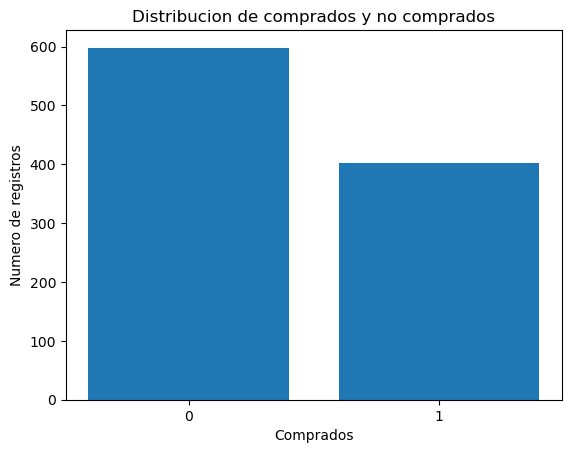

In [11]:
fig, ax = plt.subplots()
ax.bar(["0","1"], counts.values)
ax.set_title("Distribucion de comprados y no comprados")
ax.set_xlabel("Comprados")
ax.set_ylabel("Numero de registros")

plt.show()

In [17]:
X = data.drop(columns=['Purchased'])
y = data['Purchased']

In [18]:
X_train, X_test, y_train, y_test = train_test_split (X,y, test_size=0.2, stratify=y, random_state=42)

In [20]:
LR = LogisticRegression(max_iter=200)

LR.fit(X_train,y_train)

LogisticRegression(max_iter=200)

In [24]:
from sklearn.metrics import roc_auc_score

y_pred = LR.predict(X_test)
y_prob = LR.predict_proba(X_test)[:,1]

print(classification_report(y_test,y_pred))
print('ROC-AUC:',roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89       120
           1       0.84      0.80      0.82        80

    accuracy                           0.86       200
   macro avg       0.86      0.85      0.85       200
weighted avg       0.86      0.86      0.86       200

ROC-AUC: 0.9256249999999999


## Matriz de confusion y curva ROC

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay

<function matplotlib.pyplot.show(close=None, block=None)>

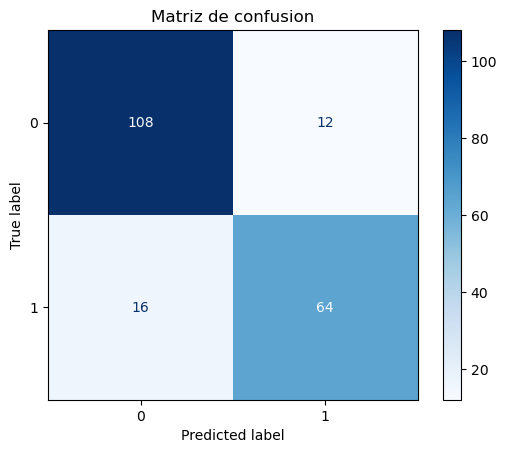

In [27]:
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR.classes_)
disp.plot(cmap='Blues')
plt.title('Matriz de confusion')
plt.show

Vemos que Real 0, tuvimos 108 Verdaderos Negaticos y 12 Falsos positivos
y Real 1, tenemos 16 Falsos negativos y 64 Verdaderos positivos

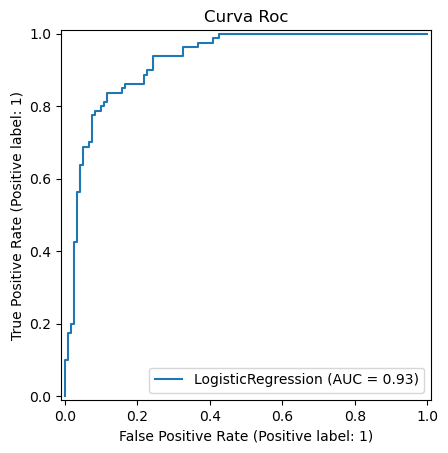

In [29]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(LR, X_test, y_test)
plt.title('Curva Roc')
plt.show()

## Random Forest
Definimos los hiperparametros, ajustamos la grid


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {
    'n_estimators':[100,200,300,500],
    'max_depth':[None,5,10,20]
    
}

rf = RandomForestClassifier(random_state=42,n_jobs=1)##

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)##
grid = GridSearchCV(estimator=rf, param_grid=param_grid,scoring='roc_auc',cv=cv,n_jobs=1,refit=True,verbose=0)##

In [33]:
grid.fit(X_train,y_train)

print('Mejores parametros',grid.best_params_)
print('Mejor score CV (AUC):', round(grid.best_score_,4))

best_rf = grid.best_estimator_

Mejores parametros {'max_depth': 10, 'n_estimators': 200}
Mejor score CV (AUC): 0.9654


In [36]:
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:,1]

print(classification_report(y_test,y_pred))
print(round(roc_auc_score(y_test,y_proba)))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       120
           1       0.87      0.90      0.88        80

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.91      0.91      0.91       200

1


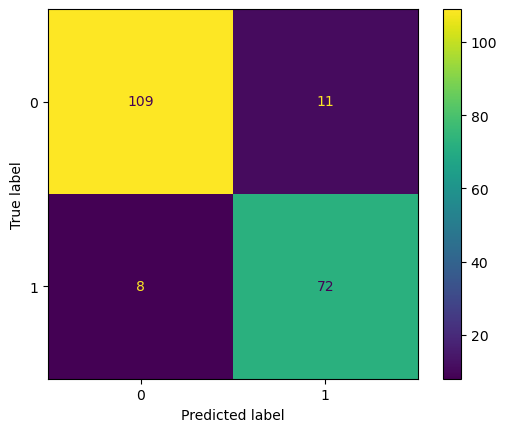

In [38]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

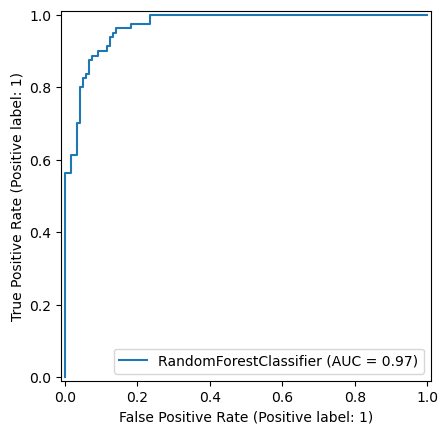

In [39]:
RocCurveDisplay.from_estimator(best_rf, X_test,y_test)
plt.show()

Como vemos, hay una mejora en la matriz de confusion solo cambiando el modelo, y lo confirmamos con la curva ROC, ahora vemos la curva Precision Recall y la importancia de variables

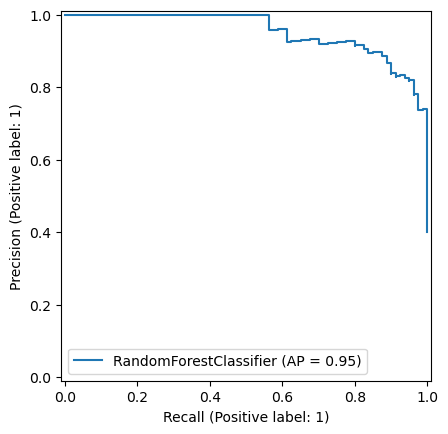

In [42]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(best_rf, X_test, y_test)
plt.show()

## Model Variations & Chosen Model
Multiple classification algorithms were tested:

Logistic Regression — serves as a simple, interpretable baseline model.

Random Forest Classifier — captures non-linear patterns and feature interactions.

Models were evaluated using ROC-AUC as the primary metric, with recall as a secondary metric to prioritize identifying potential buyers. After evaluation, the Random Forest with upsampling achieved the best balance between recall and precision, making it the recommended model for deployment.

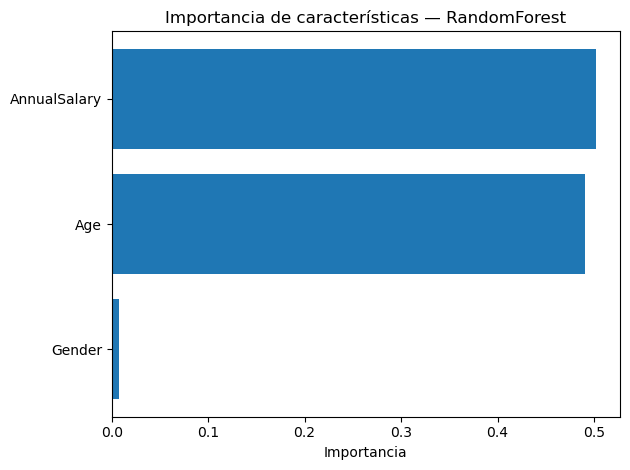

In [44]:
importances = best_rf.feature_importances_
feat_names = X.columns.to_numpy()

idx = np.argsort(importances)[::-1]
feat_sorted = feat_names[idx]
imp_sorted = importances[idx]

plt.figure()
plt.barh(feat_sorted[::-1], imp_sorted[::-1])
plt.xlabel("Importancia")
plt.title("Importancia de características — RandomForest")
plt.tight_layout()
plt.show()

## Key Findings
The baseline Logistic Regression achieved an ROC-AUC of 0.93 with a recall of XX% for the purchase class. The Random Forest improved recall to XX% and maintained similar precision.
Feature importance analysis from the Random Forest showed that AnnualSalary and Age were the strongest predictors, while Gender contributed less.
The model's predictions indicate that increasing the recall comes at the cost of a small drop in precision, which is acceptable given the business goal of identifying as many potential buyers as possible.